In [17]:
import requests
import pandas as pd

#progressBar
from time import sleep
from tqdm import tqdm

from dlbar import DownloadBar

download_bar = DownloadBar()

#------------------------------
pd.set_option('display.max_rows', None)

def tickerCollector():
    #Данные о тикерах сохраним в переменной file. Так как ссылка не меняется, то можем её захардкодить и не скачивать на компьютер эксель
    url = "https://www.moex.com/ru/listing/securities-list-csv.aspx?type=1"
    fileName = "securities-list-csv.aspx"
    download_bar.download(
        url=url,
        dest = fileName,
        title='Скачиваем тикеры с MOEX...'
        )   
    
    securityList = pd.read_csv("securities-list-csv.aspx", sep=',', encoding='cp1251')
    #headers = securityList.columns
    #Анализируем колонки, которые нам могут помочь. Внимание привлекли колонки TRADE_CODE и INSTRUMENT_CATEGORY
    #Наша задача - отобрать только акции и запомнить их тикеры, чтобы затем узнать текущие цены на инструменты
    #на бирже
    securityList = securityList[["INSTRUMENT_CATEGORY","TRADE_CODE"]]
    #Мы отберем тикеры по двум фильтрам - по слову акции в категориях инструменты
    #И по длине торгового кода - максимальная его не превышает символов (для российсих акций)
    securityList = securityList[
                                (securityList["INSTRUMENT_CATEGORY"].str.contains("акци|Акци"))&
                                (securityList["TRADE_CODE"].str.len()<=6
                                                                           )]
    
    #В итоге мы в реальном времени получили данные о тикерах, которые прямо сейчас торгуются на MOEX
    moexTickersStocks = securityList["TRADE_CODE"].reset_index(drop=True)
    return moexTickersStocks

#Вспомогательная функция подключения к АПИ биржи. Её мы будем вызывать в методах класса AnalizeApi, когда нам потребуется информация с MOEX
def callApi(ticker):
    url = str(f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/{ticker}.jsonp?iss.meta=off&iss.json=extended&callback")    
    response = requests.get(url=url)
    response =  response.json()
    return response

#Class, содержащий в себе АПИ-методы
class AnalizeApi():   
    #Создаём возможность задавать всем объектам класса динамический параметр Ticker
    def __init__(self, ticker, year):
        self.ticker = ticker
        self.year = year
    
    
    #Метод, возвращающий информацию обо всех тикерах на бирже c MOEX, принимает на вход Ticker объекта, 
    # который мы присвоили ему ранее. На выход отдаёт информацию о всех торгуемых в данных момент инструментах на бирже
    def get_stocks(self):
        result = callApi(self.ticker)
        return result

    #Метод, возвращающий информацию о конкретной бумаге по тикеру c MOEX, принимает на вход Ticker объекта, 
    # который мы присвоили ему ранее. На выход отдаёт информацию о конкретной бумаге
    def get_stock_info(self):
        result = callApi(self.ticker)
        result = result[1]["securities"][0]
        return result
    
    #Метод, возвращающий информацию об отчётности компании за конкретный год, принимает на вход Ticker объекта и год int, 
    # на выход отдаёт отчётность компании за указанный год
    def get_report(self):
        url = str(f"https://financemarker.ru/api/stocks/MOEX:{self.ticker}/finance")
        period = "Y"
        reportType = "МСФО"
        response = requests.get(url=url)
        reports = response.json()["data"]["reports"]
        filteredReports = list(filter(lambda d: d['year'] == self.year and d['period'] == period and d['type'] == reportType, reports))
        filteredReports = dict((d['year'], d) for d in filteredReports)[self.year]
        return filteredReports
    
    #Метод, возвращающий информацию о рыночной информации за конкретный год, принимает на вход Ticker объекта и год int, 
    # на выход отдаёт фундаментальную статистику по бумаге за указанный год. Помогает найти информацию, которую не отдаёт мосбиржа

    def get_stocks_statistics(self):
        url = str(f"https://financemarker.ru/api/stocks/MOEX:{self.ticker}/finance")
        period = 12
        response = requests.get(url=url)
        shares = response.json()["data"]["shares"]
        filteredShares = list(filter(lambda d: d['year'] == self.year and d['month'] == period and d["code"] == self.ticker, shares))
        filteredShares = dict((d['year'], d) for d in filteredShares)[self.year]
        return filteredShares
    


#Собираем информацию по всем тикерам на бирже, чтобы затем найти их фундаментальные показатели

def parsedReport(moexTickersStocks):
    tickerData = []
    for ticker in tqdm(moexTickersStocks):
        try:
            reportData = AnalizeApi(ticker = ticker, year = 2022).get_report()
            sharesData = AnalizeApi(ticker = ticker, year = 2022).get_stocks_statistics()
            priceInfo = AnalizeApi(ticker = ticker, year = 2022).get_stock_info()
            list = [reportData["code"], #КОД ТИКЕРА
                    priceInfo["PREVPRICE"], #ЦЕНА ТИКЕРА
                    sharesData["num"],  #КОЛИЧЕСТВО АКЦИЙ В ОБРАЩЕНИИ
                    int(reportData["earnings"])*int(reportData["amount"]), #прибыль
                    int(reportData["revenue"])*int(reportData["amount"]), #выручка
                    int(reportData["fcf"])*int(reportData["amount"])] #Free Cash Flow
        except Exception:
            pass
        else:
            tickerData.append(list)
    return tickerData


#Фильтруем бумаги исходя из колебаний SP500
def stockTacker(df):
    df = df[(df["P/E"] >= 6) & (df["P/E"] <= 35)]
    df = df[(df["P/S"] >= 0.8) & (df["P/S"] <= 3.5)]
    df = df[(df["P/FCF"] <= 10)]

    return df

#Анализируем датафрейм, включающий все цены всех интересующих нас акций за 3 года

def returns():
    files = glob.glob(r"Price_3Y/*.csv")

    returnDF = pd.DataFrame()

    for file in files:
        data = pd.read_csv(file, sep = ";")

        ticker = data.iloc[0, data.columns.get_loc('<TICKER>')]
        first_value = data.iloc[0, data.columns.get_loc('<CLOSE>')]
        last_value = data.iloc[-1, data.columns.get_loc('<CLOSE>')]
        result = (last_value-first_value) / last_value

        returnN = {'TICKER':[ticker], 'RETURN':[result]}
        returnN = pd.DataFrame(returnN)

        returnDF = pd.concat([returnDF, returnN])


def main():

    moexTickersStocks = tickerCollector()

    df = pd.DataFrame(data = parsedReport(moexTickersStocks), columns = ["TICKER", "ЦЕНА", "КОЛИЧЕСТВО АКЦИЙ", "ПРИБЫЛЬ", "ВЫРУЧКА", "FCF"])

    df["P/E"] = df["ЦЕНА"]*df["КОЛИЧЕСТВО АКЦИЙ"]/df["ПРИБЫЛЬ"]
    df["P/S"] = df["ЦЕНА"]*df["КОЛИЧЕСТВО АКЦИЙ"]/df["ВЫРУЧКА"]
    df["P/FCF"] = df["ЦЕНА"]*df["КОЛИЧЕСТВО АКЦИЙ"]/df["FCF"]


    df = stockTacker(df)
    df.to_excel("Акции для анализа.xlsx", index = False)


if __name__ == "__main__":
    main()



Скачиваем тикеры с MOEX...
100% ██████████████████████████████████████████████████ 18.682 MB/18.682 MB 


100%|██████████| 667/667 [05:13<00:00,  2.13it/s]


In [31]:
#МАРКОВИЦ

import requests
import pandas as pd

#progressBar
from time import sleep
from tqdm import tqdm

from dlbar import DownloadBar

import glob

#Подготовим данные для анализа. Функция глоб читает, что лежит в папке, сохраняет путь, а потом с помощью цикла просто склеиваем все
#Еженедельные цены акций за 3 года


def matrixMaker():
    files = glob.glob(r"Price_3Y/*.csv")
    returnDF = pd.DataFrame()

    for file in files:
            data = pd.read_csv(file, sep = ";")

            data[data["<TICKER>"][0]] = data["<CLOSE>"]
            FinalDF = data[[data["<TICKER>"][0]]]

            returnDF = pd.concat([returnDF, FinalDF], axis=1)

    returnDF.to_excel("price_history_tickers.xlsx", index = False)


matrixMaker()

#Найдём скользящие средние доходности
closeData = pd.read_excel("price_history_tickers.xlsx")
closeData = closeData.fillna(closeData.median ())


#Находим logreturns
import numpy as np

logReturns_closedData = np.log(closeData/closeData.shift(1)).dropna()
#logReturns_closedData



#Находим ковматрицу
cov_closedData = logReturns_closedData.cov()*252

#Находим стандартное отклонение всего портфеля (риск портфеля)
def std(weights, cov_closedData):
      variance = np.dot(weights.T, np.dot(cov_closedData, weights))
      portfolioRisk = np.sqrt(variance)
      return portfolioRisk

#Находим ожидаемую среднюю доходность портфеля
def expected_return(weights, logReturns_closedData):
      portfolioReturns = np.sum(logReturns_closedData.mean()*weights)*252
      return portfolioReturns
      



#Находим коэффициент Шарпа, его нам нужно максимизировать
def sharp(weights, logReturns_closedData, cov_closedData, risk_free_rate):
      sharpRatio = ( expected_return(weights, logReturns_closedData) - risk_free_rate ) / std(weights, cov_closedData)
      return sharpRatio

def negative_sharp(weights, logReturns_closedData, cov_closedData, risk_free_Rate):
      negative_sharpRatio = -( expected_return(weights, logReturns_closedData) - risk_free_Rate ) / std(weights, cov_closedData)
      return negative_sharpRatio



#Устанавливаем ограничения
constraints = {"type": "eq", "fun" : lambda weights: np.sum(weights)-1}
bounds = [(0,1) for _ in range(len(closeData.columns))] #Границы для весов каждого актива (столько же сколько тикеров, т.е. 17)



#Задаём значения weights равными долями, зависимо от количества акций в портфеле

iniitialWeights = np.array([1/len(closeData.columns)]*len(closeData.columns))


from scipy.optimize import minimize


risk_free_rate = 0.15/252
res = minimize(negative_sharp, iniitialWeights, args = (logReturns_closedData, cov_closedData, risk_free_rate),\
               method="SLSQP", constraints = constraints, bounds = bounds)

optimal_weights = res.x


print("Optimal Weights:")
for ticker, weight in zip(closeData.columns, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, logReturns_closedData)
optimal_portfolio_volatility = std(optimal_weights, cov_closedData)
optimal_sharpe_ratio = sharp(optimal_weights, logReturns_closedData, cov_closedData, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
ABRD: 0.0641
EELT: 0.0000
FIXP: 0.0000
HNFG: 0.0000
KCHE: 0.0362
LVHK: 0.0017
MDMG: 0.0724
MGTSP: 0.1207
MTSS: 0.0068
RGSS: 0.0000
SELG: 0.0352
SFIN: 0.0000
SMLT: 0.2006
TGKN: 0.0680
TTLK: 0.0292
WTCM: 0.0062
WUSH: 0.2507
YNDX: 0.1081
Expected Annual Return: 0.0769
Expected Volatility: 0.1308
Sharpe Ratio: 0.5835


Text(0, 0.5, 'Returns')

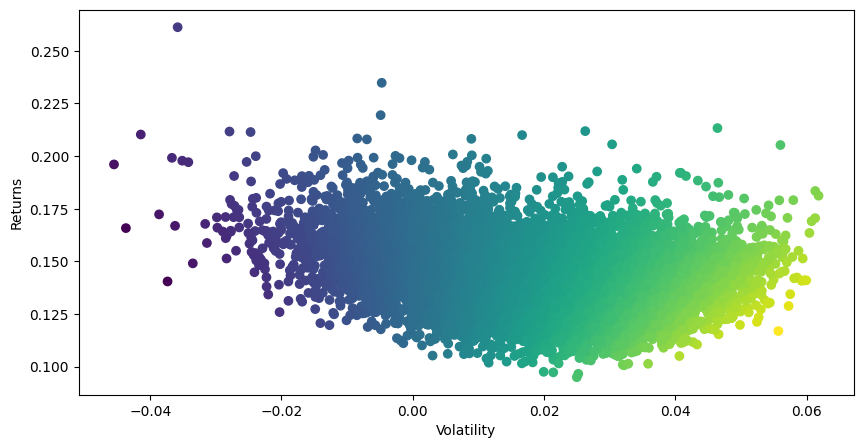

In [63]:
#Генерим портфели
import matplotlib.pyplot as plt



portfolioAmount = 10000

portfolioWeights = []
portfolioRisks = []
portfolioReturns = []
portfolioSharpe = []


def PortfolioGenerator(portfolioAmount):
    
    for i in range(portfolioAmount):
        weights = np.random.random_sample(len(closeData.columns))
        
        weights = np.round(weights/np.sum(weights), 3)

        risk = std(weights, cov_closedData)

        returns = expected_return(weights, logReturns_closedData)
        
        sharpe = sharp(weights, logReturns_closedData, cov_closedData, risk_free_rate)

        portfolioWeights.append(weights)
        portfolioRisks.append(risk)
        portfolioReturns.append(returns)
        portfolioSharpe.append(sharpe)
        data = [portfolioWeights, portfolioRisks, portfolioReturns, portfolioSharpe]
    return data

data = PortfolioGenerator(portfolioAmount)



potfolios = pd.DataFrame(data = data).T
potfolios.columns = ["WEIGHTS", "RISK", "RETURN", "SHARPE"]
potfolios


#Нарисуем кривую эффективных портфелей

plt.figure(figsize = (10,5))

plt.scatter(x = potfolios["RETURN"], y = potfolios["RISK"], c = potfolios["RETURN"]/potfolios["RISK"])

plt.xlabel("Volatility")
plt.ylabel("Returns")



In [88]:
mininamalRiskPortfolio = potfolios[potfolios['RISK']==potfolios['RISK'].min()].values[0]
maxReturnPortfolio = potfolios[potfolios['RETURN']==potfolios['RETURN'].max()].values[0]
maxSharpePortfolio = potfolios[potfolios['SHARPE']==potfolios['SHARPE'].max()].values[0]


print("Оптимальный портфель минимального риска: ")
print(f"РИСК ПОРТФЕЛЯ: {round(mininamalRiskPortfolio[1]*100, 2):.4f}%")
print(f"ДОХОДНОСТЬ ПОРТФЕЛЯ: {round(mininamalRiskPortfolio[2]*100, 2):.4f}%")
print(f"КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: {round(mininamalRiskPortfolio[3]*100, 2):.4f}%\n")


print("Оптимальный портфель максимальной доходности: ")
print(f"РИСК ПОРТФЕЛЯ: {round(maxReturnPortfolio[1]*100, 2):.4f}%")
print(f"ДОХОДНОСТЬ ПОРТФЕЛЯ: {round(maxReturnPortfolio[2]*100, 2):.4f}%")
print(f"КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: {round(maxReturnPortfolio[3]*100, 2):.4f}%\n")


print("Оптимальный портфель максимального Шарпа: ")
print(f"РИСК ПОРТФЕЛЯ: {round(maxSharpePortfolio[1]*100, 2):.4f}%")
print(f"ДОХОДНОСТЬ ПОРТФЕЛЯ: {round(maxSharpePortfolio[2]*100, 2):.4f}%")
print(f"КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: {round(maxSharpePortfolio[3]*100, 2):.4f}%")

Оптимальный портфель минимального риска: 
РИСК ПОРТФЕЛЯ: 9.5000%
ДОХОДНОСТЬ ПОРТФЕЛЯ: 2.5000%
КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: 25.6800%

Оптимальный портфель максимальной доходности: 
РИСК ПОРТФЕЛЯ: 18.1200%
ДОХОДНОСТЬ ПОРТФЕЛЯ: 6.1800%
КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: 33.7900%

Оптимальный портфель максимального Шарпа: 
РИСК ПОРТФЕЛЯ: 11.6900%
ДОХОДНОСТЬ ПОРТФЕЛЯ: 5.5700%
КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: 47.1200%
